# Running a ReCom Chain on Connecticut
* Set Up the chain
* @author Blayde Omura and Lisa Jurca
* AI for Redistricting final project on Connecticut

In [1]:
from gerrychain.random import random
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom
from functools import partial
import pandas as pd
import geopandas as gpd
import csv
import os
import datetime  #For keeping track of runtime
import tqdm # for progress bar
import numpy as np
random.seed(12345678)

Create a directory that stores files for analysis

In [2]:
outdir="./CT_recom"

Here are parameters that we can change later if needed

In [3]:
total_steps_in_run=1500
save_district_graph_mod=1
save_district_plot_mod=100

Import the graph 

In [4]:
os.makedirs(outdir, exist_ok=True)
ct_df = gpd.read_file("./CT/CT.shp")

print(ct_df.columns)

graph = Graph.from_geodataframe(ct_df)

Index(['STATEFP20', 'COUNTYFP20', 'NAME20', 'G16PREDCLI', 'G16PRERTRU',
       'G16PRELJOH', 'G16PREGSTE', 'G16PREOWRI', 'G16USSDBLU', 'G16USSRCAR',
       'G16USSLLIO', 'G16USSGRUS', 'G16USSOWRI', 'TOTPOP', 'HISP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
       'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP',
       'OTHERVAP', '2MOREVAP', 'CD', 'geometry'],
      dtype='object')


These are the elections we have available:

In [5]:
elections = [
    Election("SEN16", {"Democratic": "G16USSDBLU", "Republican": "G16USSRCAR"}),
    Election("PRES16", {"Democratic": "G16PREDCLI", "Republican": "G16PRERTRU"})
]

"TOT_POP" is the population column from our shapefile

In [6]:
my_updaters = {"population": updaters.Tally("TOTPOP", alias="population")} # updaters, need to keep total population

Election updaters, for computing election results using the vote totals from our shapefile.

In [7]:
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

Create the partition

In [8]:
initial_partition = GeographicPartition(graph, 
                                        assignment= "CD", 
                                        updaters=my_updaters)

The ReCom proposal needs to know the ideal population for the districts so that we can improve speed by bailing early on unbalanced partitions.

In [9]:
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition) # total pop / num districts

Create a proposal

In [10]:
proposal = partial(recom,
                   pop_col="TOTPOP",
                   pop_target=ideal_population,
                   epsilon=0.02,  # can change to 5%
                   node_repeats=2
                  )

In [11]:
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

In [12]:
pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.02)

Create the markov chain

In [13]:
chain = MarkovChain( # markov chain
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=total_steps_in_run
    )

## Marginal Box Plots Democratic Senate 16 Election

In [14]:
# data frame that keeps track of percent democratic and sort it
data = pd.DataFrame(
    sorted(partition["SEN16"].percents("Democratic"))
    for partition in chain.with_progress_bar()
)

  0%|          | 0/1500 [00:00<?, ?it/s]

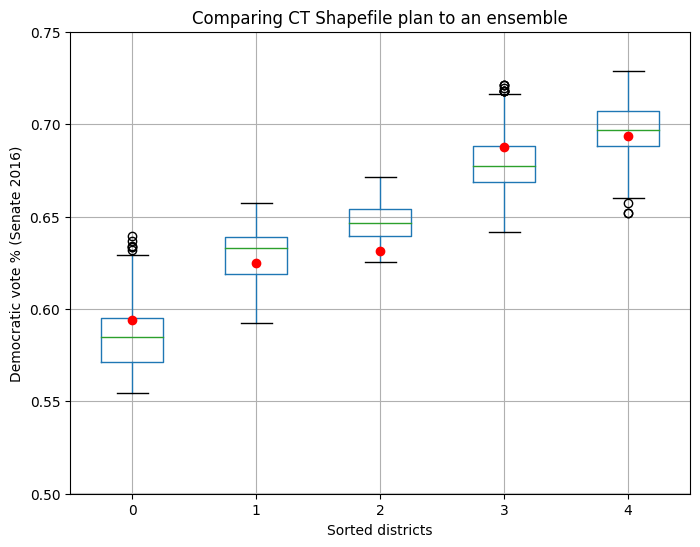

In [15]:
# makes box plots look reasonable
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
data.boxplot(ax=ax, positions=range(len(data.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row, which corresponds to the initial plan)
plt.plot(data.iloc[0], "ro")

# Annotate
ax.set_title("Comparing CT Shapefile plan to an ensemble")
ax.set_ylabel("Democratic vote % (Senate 2016)")
ax.set_xlabel("Sorted districts")
ax.set_ylim(.50, .75)
ax.set_yticks([0.5, 0.55, 0.60, 0.65, 0.7, 0.75])

plt.show()

* Blue box: 25th-75th percentile
* Green horizontal box: the median
* Black x circles: outliers

## Marginal Box Plots Republicans Senate 16 Election

In [16]:
# data frame that keeps track of percent democratic and sort it
data_rep_uss = pd.DataFrame(
    sorted(partition["SEN16"].percents("Republican"))
    for partition in chain.with_progress_bar()
)

  0%|          | 0/1500 [00:00<?, ?it/s]

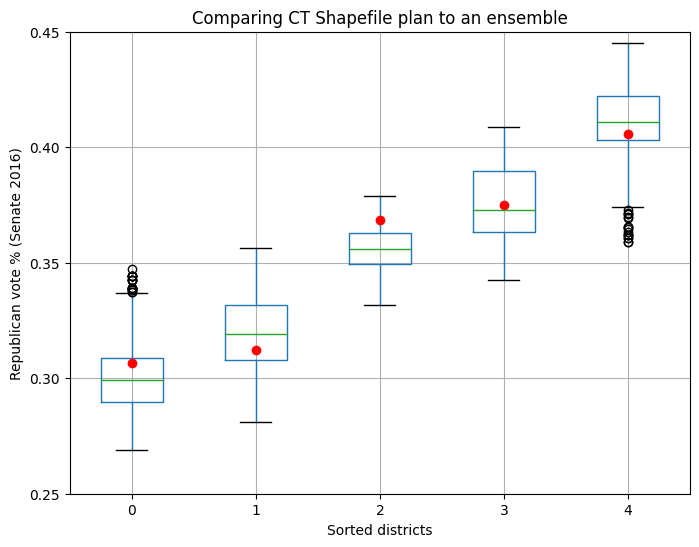

In [17]:
# makes box plots look reasonable
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
data_rep_uss.boxplot(ax=ax, positions=range(len(data_rep_uss.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row, which corresponds to the initial plan)
plt.plot(data_rep_uss.iloc[0], "ro")

# Annotate
ax.set_title("Comparing CT Shapefile plan to an ensemble")
ax.set_ylabel("Republican vote % (Senate 2016)")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0.25, .45)
ax.set_yticks([0.25, 0.3, 0.35, 0.4, 0.45])

plt.show()

* Blue box: 25th-75th percentile
* Green horizontal box: the median
* Black x circles: outliers

## Marginal Box Plots Demcratcs Presidential 16 Election

In [18]:
# data frame that keeps track of percent democratic and sort it
data_dem_pres = pd.DataFrame(
    sorted(partition["PRES16"].percents("Democratic"))
    for partition in chain.with_progress_bar()
)

  0%|          | 0/1500 [00:00<?, ?it/s]

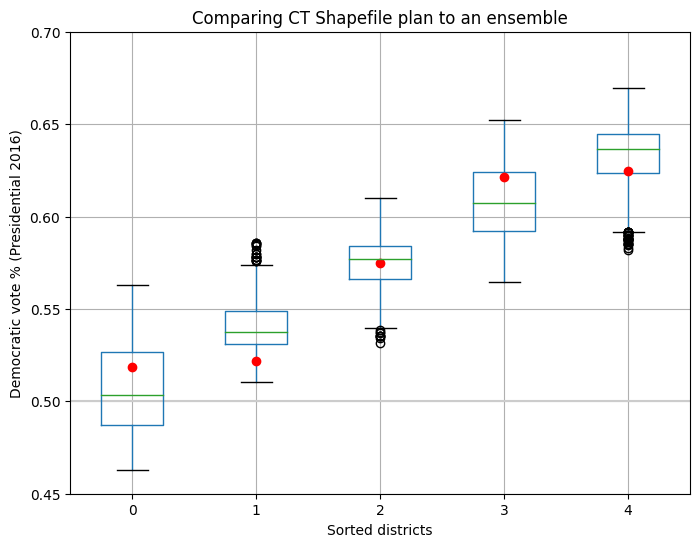

In [19]:
# makes box plots look reasonable
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
data_dem_pres.boxplot(ax=ax, positions=range(len(data_dem_pres.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row, which corresponds to the initial plan)
plt.plot(data_dem_pres.iloc[0], "ro")

# Annotate
ax.set_title("Comparing CT Shapefile plan to an ensemble")
ax.set_ylabel("Democratic vote % (Presidential 2016)")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0.45, .7)
ax.set_yticks([0.45, 0.5, 0.55, 0.6, 0.65, 0.7])

plt.show()

* Blue box: 25th-75th percentile
* Green horizontal box: the median
* Black x circles: outliers

## Marginal Box Plots Democrats Presidential 16 Election

In [20]:
# data frame that keeps track of percent democratic and sort it
data_rep_pres = pd.DataFrame(
    sorted(partition["PRES16"].percents("Republican"))
    for partition in chain.with_progress_bar()
)

  0%|          | 0/1500 [00:00<?, ?it/s]

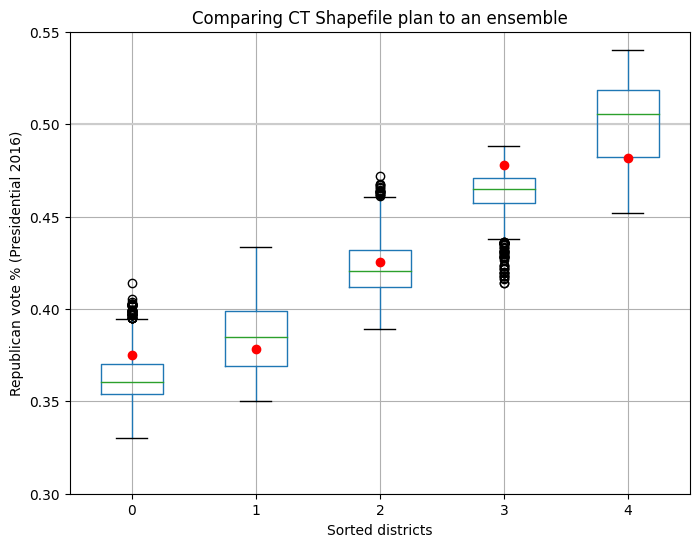

In [21]:
# makes box plots look reasonable
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
data_rep_pres.boxplot(ax=ax, positions=range(len(data_rep_pres.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row, which corresponds to the initial plan)
plt.plot(data_rep_pres.iloc[0], "ro")

# Annotate
ax.set_title("Comparing CT Shapefile plan to an ensemble")
ax.set_ylabel("Republican vote % (Presidential 2016)")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0.3, 0.55)
ax.set_yticks([0.3, 0.35, 0.4, 0.45, 0.5, 0.55])

plt.show()

* Blue box: 25th-75th percentile
* Green horizontal box: the median
* Black x circles: outliers

# Outlier Analysis

### Run our random walk to be able to create histograms

In [22]:
pres_egaps = []
sen_egaps = []
pres_mmd = []
sen_mmd = []
cutedge_ensemble = []
pres_dem_won_districts = []
pres_rep_won_districts = []
sen_dem_won_districts = []
sen_rep_won_districts = []

# The ElectionResults object for "SEN16"
sen_election_results = initial_partition["SEN16"]

# Use the wins method to get the number of districts won by each party
sen_dem_won_districts = sen_election_results.wins("Democratic")
sen_rep_won_districts = sen_election_results.wins("Republican")

for partition in chain:
    # Add cutedges to cutedges ensemble
    cutedge_ensemble.append(len(partition["cut_edges"]))

    # Storing efficiency gap metrics
    pres_egaps.append(partition["PRES16"].efficiency_gap())
    sen_egaps.append(partition["SEN16"].efficiency_gap())

    # Storing mean median metrics
    pres_mmd.append(partition["PRES16"].mean_median())
    sen_mmd.append(partition["SEN16"].mean_median())

    # Pres District won
    pres_dem_won_districts.append(partition["PRES16"].wins("Democratic"))
    pres_rep_won_districts.append(partition["PRES16"].wins("Republican"))

    # Sen District won
    pres_dem_won_districts.append(partition["SEN16"].wins("Democratic"))
    pres_rep_won_districts.append(partition["SEN16"].wins("Republican"))

## Efficiency Gap 

### Plot the Presidential Histogram and Calculate Efficiency gap

In [23]:
# Efficiency gap calculation here for scatter plot
pres_eff_gap = initial_partition["PRES16"].efficiency_gap()

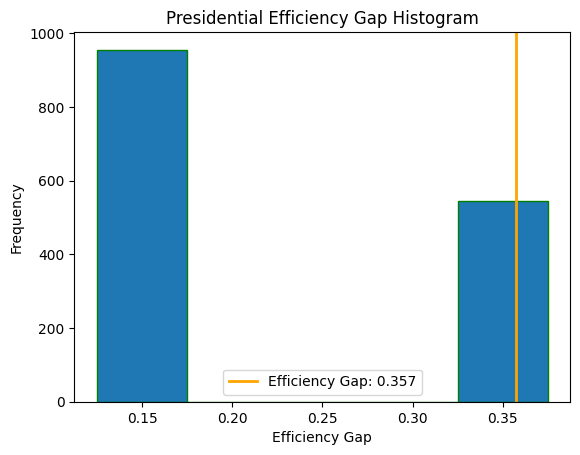

In [24]:
# Define the bin edges such that they center the bars over the labels
bin_edges = [0.125, 0.175, 0.225, 0.275, 0.325, 0.375]

# Plot our histogram with specified bins
plt.figure()
plt.hist(pres_egaps, bins=bin_edges, edgecolor="green", align='mid')
plt.title('Presidential Efficiency Gap Histogram')
plt.xlabel('Efficiency Gap')
plt.ylabel('Frequency')

# Overlay line on top of histogram
plt.axvline(x=pres_eff_gap, color='orange', label=f'Efficiency Gap: {pres_eff_gap:.3f}', linewidth=2)
plt.legend()  # Show legend with the label of scatter

plt.show()

In [25]:
print(f"Presidential Efficiency Gap: {pres_eff_gap}")

Presidential Efficiency Gap: 0.35716904965472723


### Plot the Senate Histogram and Calculate Efficiency gap

In [26]:
# Efficieny gap calculation for scatter plot
sen_eff_gap = initial_partition["SEN16"].efficiency_gap()

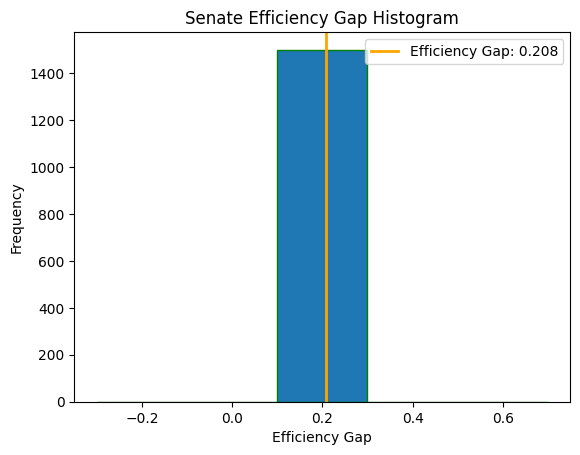

In [27]:
# Plot our histogram
plt.figure()
bins = [-.3, -.1, .1, .3, 0.5, 0.7]
plt.hist(sen_egaps, bins, edgecolor = "green", align='mid')
plt.title('Senate Efficiency Gap Histogram')
plt.xlabel('Efficiency Gap')
plt.ylabel('Frequency')

# Overlay sline on top of histogram
plt.axvline(x=sen_eff_gap, color='orange', label=f'Efficiency Gap: {sen_eff_gap:.3f}', linewidth=2) # sets the veritcal line
plt.legend()  # Show legend with the label of scatter

plt.show()

In [28]:
print(f"Senate Efficiency Gap: {sen_eff_gap}")

Senate Efficiency Gap: 0.20788267732421292


# Mean Median Difference

### Plot Presidential Mean Median Difference

In [29]:
# Calculate presidential mmd 
pres_mean_median_diff = initial_partition["PRES16"].mean_median()

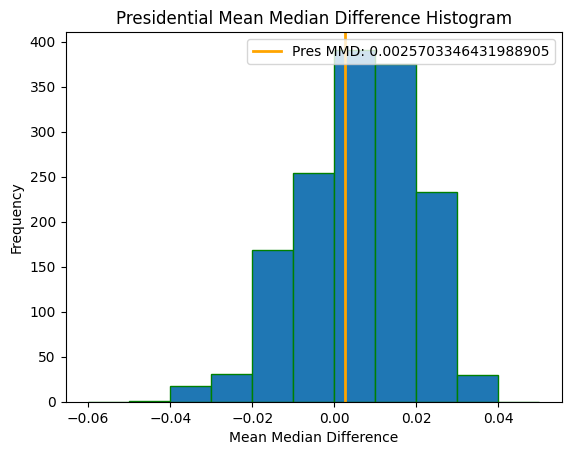

In [30]:
# Plot our histogram
bins = [-.06, -.05, -.04, -.03, -0.02, -.01, 0, .01, .02, .03, .04, .05]
plt.figure()
plt.hist(pres_mmd, bins, edgecolor = "green", align='mid')
plt.title('Presidential Mean Median Difference Histogram')
plt.xlabel('Mean Median Difference')
plt.ylabel('Frequency')

# Overlay line on top of histogram
plt.axvline(x=pres_mean_median_diff, color='orange', label=f'Pres MMD: {pres_mean_median_diff:}', linewidth=2) # sets the veritcal line
plt.legend()  # Show legend with the label of scatter

plt.show()

In [31]:
print(f"Presidential Mean-Median Difference: {pres_mean_median_diff}")

Presidential Mean-Median Difference: 0.0025703346431988905


### Senate Mean Median Difference

In [32]:
# Calculate Senate mmd
sen_mean_median_diff = initial_partition["SEN16"].mean_median()

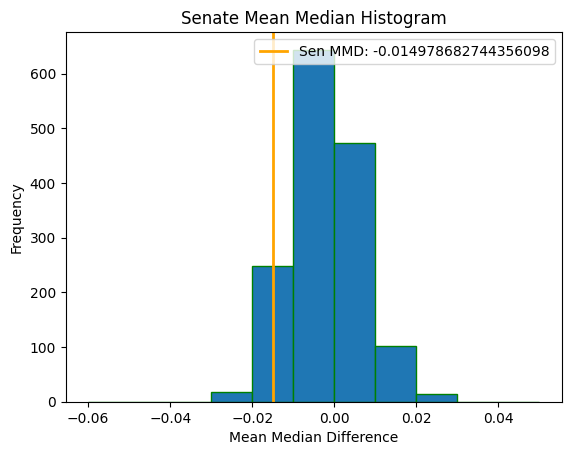

In [33]:
# Plot our histogram
bins = [-.06, -.05, -.04, -.03, -0.02, -.01, 0, .01, .02, .03, .04, .05]
plt.figure()
plt.hist(sen_mmd, bins, edgecolor = "green", align='mid')
plt.title('Senate Mean Median Histogram')
plt.xlabel('Mean Median Difference')
plt.ylabel('Frequency')

# Overlay sline on top of histogram
plt.axvline(x=sen_mean_median_diff, color='orange', label=f'Sen MMD: {sen_mean_median_diff:}', linewidth=2) # sets the veritcal line
plt.legend()  # Show legend with the label of scatter

plt.show()

In [34]:
print(f"Senate Mean-Median Difference: {sen_mean_median_diff}")

Senate Mean-Median Difference: -0.014978682744356098


# Democratic vs Republican Won Districts

## Presidential Democratic Won Districts

In [35]:
# Calculate Presidential Won Districts for Democrats
pres_dem_won_districts_plot = initial_partition["PRES16"].wins("Democratic")

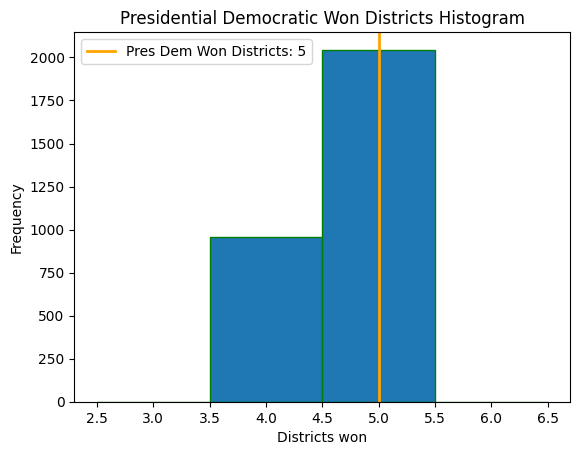

In [36]:
# Plot our histogram
plt.figure()
bins = [2.5, 3.5, 4.5, 5.5, 6.5]
plt.hist(pres_dem_won_districts, bins, edgecolor = "green", align='mid')
plt.title('Presidential Democratic Won Districts Histogram')
plt.xlabel('Districts won')
plt.ylabel('Frequency')

# Line plot won districts
plt.axvline(x=pres_dem_won_districts_plot, color='orange', label=f'Pres Dem Won Districts: {pres_dem_won_districts_plot:}', linewidth=2) # sets the veritcal line
plt.legend()  # Show legend with the label of scatter
plt.show()

In [37]:
print(f"Presidential Democratic Won Districts: {pres_dem_won_districts_plot}")

Presidential Democratic Won Districts: 5


## Presidential Republican Won Districts

In [38]:
# Calculate Presidential Won Districts for Republican
pres_rep_won_districts_plot = initial_partition["PRES16"].wins("Republican")

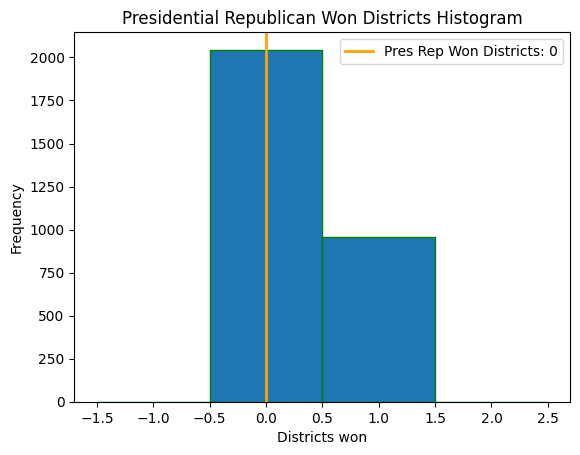

In [39]:
# Plot our histogram
plt.figure()
bins = [-1.5, -.5, .5, 1.5, 2.5]
plt.hist(pres_rep_won_districts, bins, edgecolor = "green", align='mid')
plt.title('Presidential Republican Won Districts Histogram')
plt.xlabel('Districts won')
plt.ylabel('Frequency')

# Line plot won districts
plt.axvline(x=pres_rep_won_districts_plot, color='orange', label=f'Pres Rep Won Districts: {pres_rep_won_districts_plot:}', linewidth=2) # sets the veritcal line
plt.legend()  # Show legend with the label of scatter
plt.show()

In [40]:
print(f"Presidential Republican Won Districts: {pres_rep_won_districts_plot}")

Presidential Republican Won Districts: 0


## Senate Democratic Won Districts

In [41]:
# Calculate Sen Won Districts for Democrats
sen_dem_won_districts_plot = initial_partition["SEN16"].wins("Democratic")

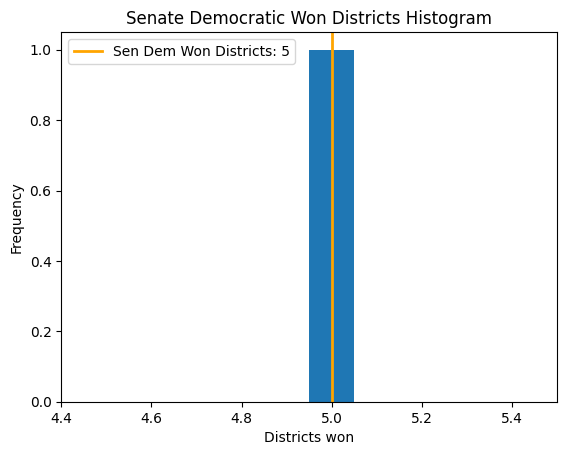

In [42]:
# Plot our histogram
plt.figure()
plt.hist(sen_dem_won_districts, align = 'left')
plt.title('Senate Democratic Won Districts Histogram')
plt.xlabel('Districts won')
plt.ylabel('Frequency')

# Line plot won districts
plt.axvline(x=sen_dem_won_districts_plot, color='orange', label=f'Sen Dem Won Districts: {sen_dem_won_districts_plot:}', linewidth=2) # sets the veritcal line

plt.legend()  # Show legend with the label of scatter

plt.show()

In [43]:
print(f"Senate Democratic Won Districts: {sen_dem_won_districts_plot}")

Senate Democratic Won Districts: 5


## Senate Republican Won Districts

In [44]:
# Calculate Senate Republican Won Districts
sen_rep_won_districts_plot = initial_partition["SEN16"].wins("Republican")

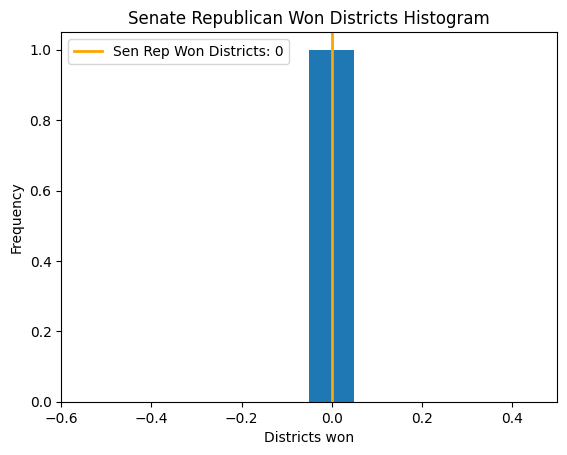

In [45]:
# Plot our histogram
plt.figure()
plt.hist(sen_rep_won_districts, align = 'left')
plt.title('Senate Republican Won Districts Histogram')
plt.xlabel('Districts won')
plt.ylabel('Frequency')

# Line plot won districts
plt.axvline(x=sen_rep_won_districts_plot, color='orange', label=f'Sen Rep Won Districts: {sen_rep_won_districts_plot:}', linewidth=2) # sets the veritcal line
plt.legend()  # Show legend with the label of scatter

plt.show()

In [46]:
print(f"Senate Republican Won Districts: {sen_rep_won_districts_plot}")

Senate Republican Won Districts: 0


# Cut Edges Histogram and Calculation

In [47]:
# Cut edges can be accessed from the partition object
number_of_cut_edges = len(initial_partition["cut_edges"])

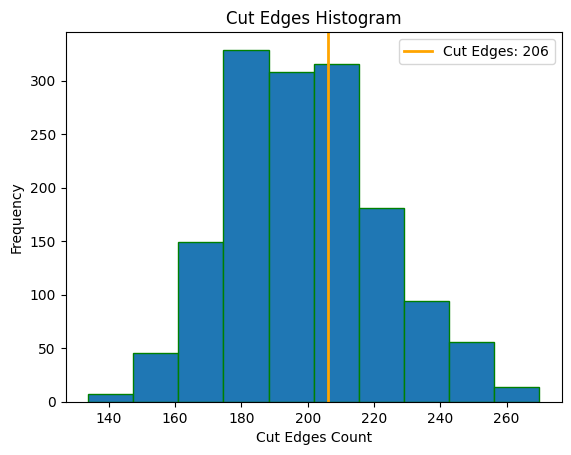

In [48]:
# Plot our histogram
plt.figure()
plt.hist(cutedge_ensemble, align = 'right', edgecolor = "green")
plt.title('Cut Edges Histogram')
plt.xlabel('Cut Edges Count')
plt.ylabel('Frequency')

# Scatter plot won districts
plt.axvline(x=number_of_cut_edges, color='orange', label=f'Cut Edges: {number_of_cut_edges:}', linewidth=2) # sets the veritcal line

plt.legend()  # Show legend with the label of scatter

plt.show()

In [49]:
print(f"Number of cut edges: {number_of_cut_edges}")

Number of cut edges: 206
